In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import datetime
import gzip
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from random import sample, randint, choice
from itertools import combinations
import statsmodels.api as sm
from scipy import stats
from scipy.stats import hypergeom, norm, binom
from scipy.stats import chi2_contingency, ttest_ind, levene, f, kruskal, chi2
from collections import Counter, OrderedDict
from matplotlib.colors import colorConverter as cC
from matplotlib.patches import Rectangle
from statsmodels.formula.api import ols
import statistics
from scipy.stats import chi2_contingency, ttest_ind, levene, f, kruskal, chi2, linregress
##
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

In [3]:
def read_completeness(cmpl):
    with open(cmpl) as handle:
        keys=[x for x in next(handle).strip('\n').split('\t') if x !='']
        cmpl_dict={f'gRNA_{i}': {i:j if i=='strain' else float(j) for i,j in zip(keys,[x for x in line.strip('\n').split('\t') if x !=''])}for i,line in enumerate(handle)}
        cmpl_dict={v['strain']:v for k,v in cmpl_dict.items()}
        df=pd.DataFrame.from_dict(cmpl_dict,orient='index')
    return(df)
#give general stats
def summary(d):
    mean=round(sum(d)/len(d),2)
    med=statistics.median(d)
    mod=statistics.mode(d)
    print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")

In [4]:
#common variables
meta='/home/jovyan/Tbeqev/Infiles/Tbeqev.meta.csv'
completeness='/home/jovyan/Tbeqev/Infiles/Tbeveq_completeness_22-04-14-15-37.txt'
completeness_kDNA_enriched='/home/jovyan/Tbeqev/Infiles/Tbeveq_kDNA_enriched_22-04-15-09-40.txt'
outdir='/home/jovyan/Tbeqev/Outfiles'
completeness_with_total_read_count='/home/jovyan/Tbeqev/Infiles/Tbeq_completeness.csv'
copy_nb='/home/jovyan/Tbeqev/Infiles/TeqTev_genome_copy_number.csv'

In [5]:
metadf=pd.read_csv(meta,index_col=0,encoding='cp1252')
#df=read_completeness(completeness)
df=pd.read_csv(completeness_with_total_read_count,index_col=0,encoding='cp1252')
combined=pd.concat([df,metadf], axis=1)
#remove contaminations 
combined=combined.drop(['Kenya-c','AnTat-4-1','AnTat-4-1-bis','Kenya-a'])
combined[['taxon','total_reads','denucleate reads', 'mapped_reads', 'mapped_reads_percentage',
       'mapped_q10', 'mapped_q10_percentage', 'total_csb3', 'mapped_csb3',
       'mapped_csb3_percentage', 'mapped_csb3_q10',
       'mapped_csb3_q10_percentage']].to_csv(f"{outdir}/Tbeq_completeness.csv")
combined['nucleate reads']=combined['total_reads']-combined['denucleate reads']
combined['mapped denucleate reads percentage']=combined['mapped_reads_percentage']
combined['mapped_reads_percentage']=round(combined['mapped_reads']/combined['total_reads']*100,1)
combined['nucleate reads percentage']=round(combined['nucleate reads']/combined['total_reads']*100,1)
#copy number
cpnb=pd.read_csv(copy_nb,index_col=0,encoding='cp1252')
cpnb['maxicircle']=cpnb[[c for c in cpnb.columns if 'maxi' in c]].fillna(0).sum(axis=1)
cpnb['total_minicircle_cp']=cpnb[[m for m in cpnb.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].sum(axis=1)
combined=pd.concat([combined,cpnb], axis=1)
combined=combined.drop(['AnTat-4-1','Kenya-a','AnTat-4-1-bis'])

In [6]:
combined['taxon'].value_counts()

taxon
T. evansi A          27
T. equiperdum OVI     4
T. equiperdum C       2
T. evansi B           1
Name: count, dtype: int64

In [7]:
combined[combined['taxon']=='T. evansi A'].index

Index(['280104', 'Alfort', 'American-Strain', 'AnTar-7', 'AnTat-3-1',
       'AnTat-3-3', 'ATCC-30019', 'ATCC30019', 'ATCC-30023', 'Canadian-Strain',
       'Colombia', 'E28', 'HAMBURG', 'Kazakstan', 'Kenya', 'Philippines',
       'STIB818', 'MCAM-ET-2013-MU-01', 'MCAM-ET-2013-MU-02',
       'MCAM-ET-2013-MU-04', 'MCAM-ET-2013-MU-05', 'MCAM-ET-2013-MU-09',
       'MCAM-ET-2013-MU-17', 'Merzouga-56', 'STIB-816', 'SVP', 'Zagora-I-17'],
      dtype='object')

nucleate reads percentage
mean: 80.78, median: 80.9, mode: 81.2, max: 96.5, min: 73.2
mapped_reads_percentage
mean: 2.66, median: 2.6, mode: 0.0, max: 5.2, min: 0.0
mapped_csb3_percentage
mean: 87.79, median: 99.0, mode: 99.0, max: 99.0, min: 13.0
mapped_csb3_q10_percentage
mean: 86.97, median: 98.5, mode: 99.0, max: 99.0, min: 4.0


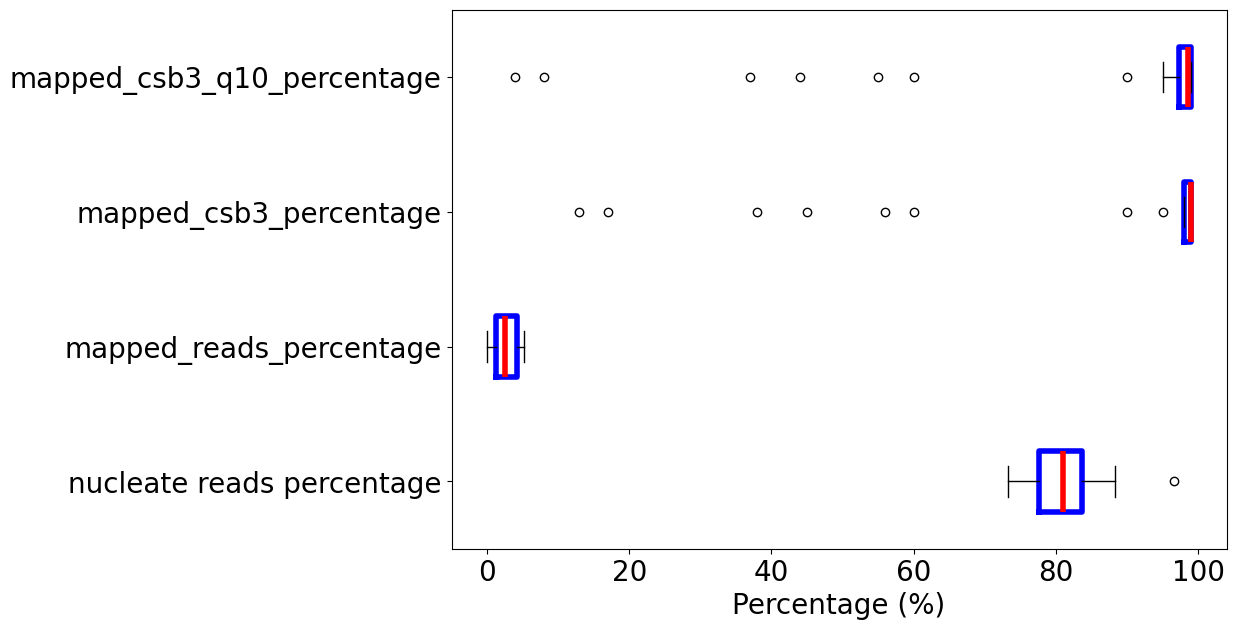

In [8]:
#some stats for completeness of mapping
def plot_completeness(df,variables):
    for c in variables:
        print(c)
        summary(df[c])
    data=df[variables]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), sharey=True)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(variables, fontsize=20)
    ax.set_xlabel(f"Percentage (%)", fontsize=20)
    plt.show()

pcvariables=['nucleate reads percentage','mapped_reads_percentage','mapped_csb3_percentage','mapped_csb3_q10_percentage']
variables=['total_csb3', 'mapped_csb3','mapped_csb3_q10']
plot_completeness(combined,pcvariables)
#plot_completeness(combined,variables)

mapped_reads_percentage
mean: 64.9, median: 65.0, mode: 66.0, max: 96.0, min: 25.0
mapped_csb3_percentage
mean: 98.9, median: 99.0, mode: 99.0, max: 99.0, min: 98.0
mapped_csb3_q10_percentage
mean: 96.5, median: 97.0, mode: 97.0, max: 98.0, min: 94.0


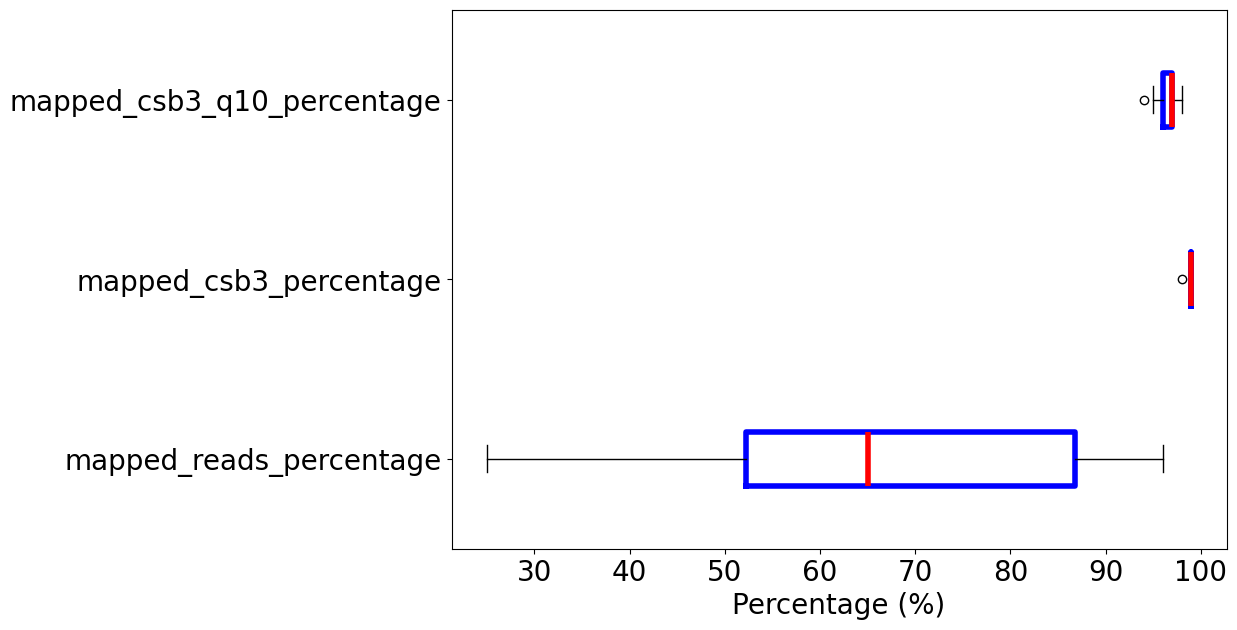

In [9]:
#for kDNA enriched data
kdf=read_completeness(completeness_kDNA_enriched)
kdf['denucleate reads']=kdf['total_reads']
kdf=kdf.drop('total_reads',axis=1)
pcvariables2=['mapped_reads_percentage','mapped_csb3_percentage','mapped_csb3_q10_percentage']
plot_completeness(kdf,pcvariables2)

nucleate reads percentage
mean: 84.63, median: 85.2, mode: 85.2, max: 87.4, min: 80.3
mapped_reads_percentage
mean: 1.86, median: 2.0, mode: 2.0, max: 4.0, min: 0.0
mapped_csb3_percentage
mean: 88.71, median: 93.0, mode: 93.0, max: 96.0, min: 59.0
mapped_csb3_q10_percentage
mean: 86.57, median: 92.0, mode: 93.0, max: 96.0, min: 58.0


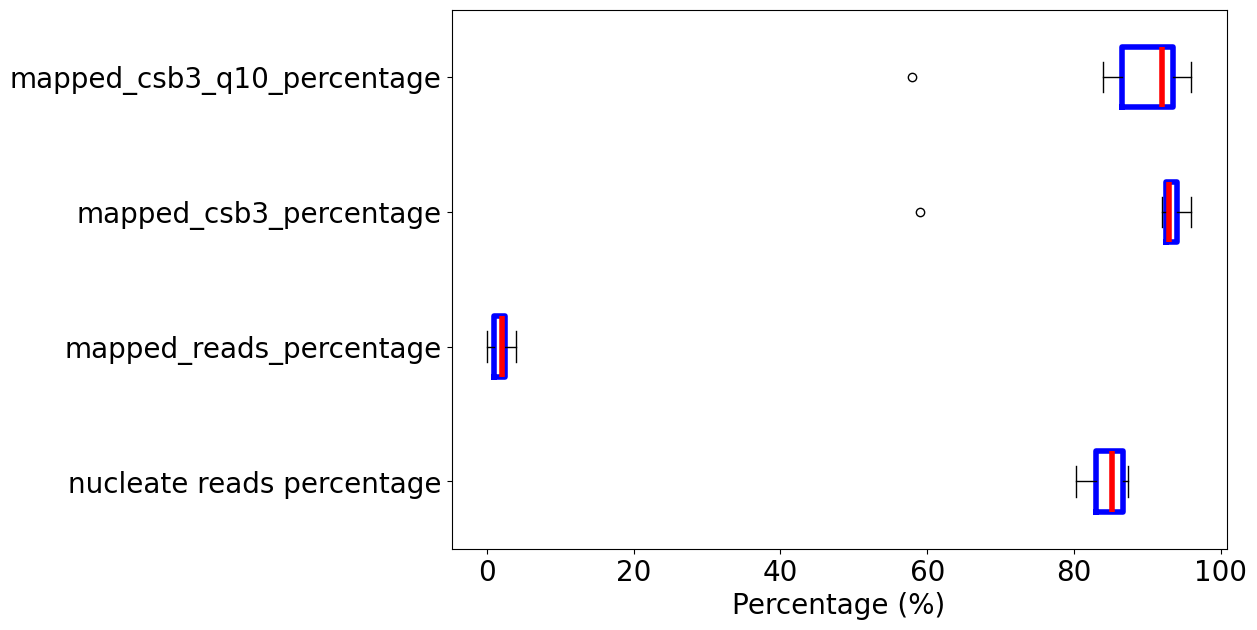

In [10]:
#WGS Cuypers and Carnes
log='/home/jovyan/Tbeqev/Infiles/Cupers_Carnes_stats_22-04-15-09-46.txt'
cdf=read_completeness(log)
cdf['total reads']=[19364254,28439312,37164010,26051420,20604924,19701740,17169524]
cdf['nucleate reads']=cdf['total reads']-cdf['denucleated_reads']
cdf['nucleate reads percentage']=round(cdf['nucleate reads']/cdf['total reads']*100,1)
plot_completeness(cdf,pcvariables)

In [11]:
cdf

,strain,denucleated_reads,mapped_reads,mapped_reads_percentage,mapped_q10,mapped_q10_percentage,total_csb3,mapped_csb3,mapped_csb3_percentage,mapped_csb3_q10,mapped_csb3_q10_percentage,total reads,nucleate reads,nucleate reads percentage
Botat-1-1_pubWGS,Botat-1-1_pubWGS,2865162.0,87078.0,3.0,86656.0,3.0,3171.0,2978.0,93.0,2978.0,93.0,19364254,16499092.0,85.2
Dodola_943_pubWGS,Dodola_943_pubWGS,3758166.0,105428.0,2.0,104840.0,2.0,4900.0,4649.0,94.0,4630.0,94.0,28439312,24681146.0,86.8
MU10_pubWGS,MU10_pubWGS,7304214.0,118158.0,1.0,116451.0,1.0,15032.0,14082.0,93.0,13898.0,92.0,37164010,29859796.0,80.3
OVI_pubWGS,OVI_pubWGS,3283262.0,50745.0,1.0,49365.0,1.0,2632.0,2438.0,92.0,2215.0,84.0,26051420,22768158.0,87.4
Rotat_1_2_pubWGS,Rotat_1_2_pubWGS,3819092.0,172215.0,4.0,172049.0,4.0,7603.0,7358.0,96.0,7357.0,96.0,20604924,16785832.0,81.5
STIB805_pubWGS,STIB805_pubWGS,3043970.0,1524.0,0.0,1475.0,0.0,344.0,205.0,59.0,202.0,58.0,19701740,16657770.0,84.5
Te-Ap-N-D1_pubWGS,Te-Ap-N-D1_pubWGS,2286666.0,52135.0,2.0,50994.0,2.0,2248.0,2119.0,94.0,2020.0,89.0,17169524,14882858.0,86.7


T. evansi A
mean: 2463.6, median: 2628.16, mode: 987.66, max: 3801.75, min: 987.66
T. evansi B
mean: 776.79, median: 776.79, mode: 776.79, max: 776.79, min: 776.79
T. equiperdum C
mean: 952.3, median: 952.2950000000001, mode: 1282.25, max: 1282.25, min: 622.34
T. equiperdum OVI
mean: 2048.42, median: 1879.8400000000001, mode: 3269.77, max: 3269.77, min: 1164.24


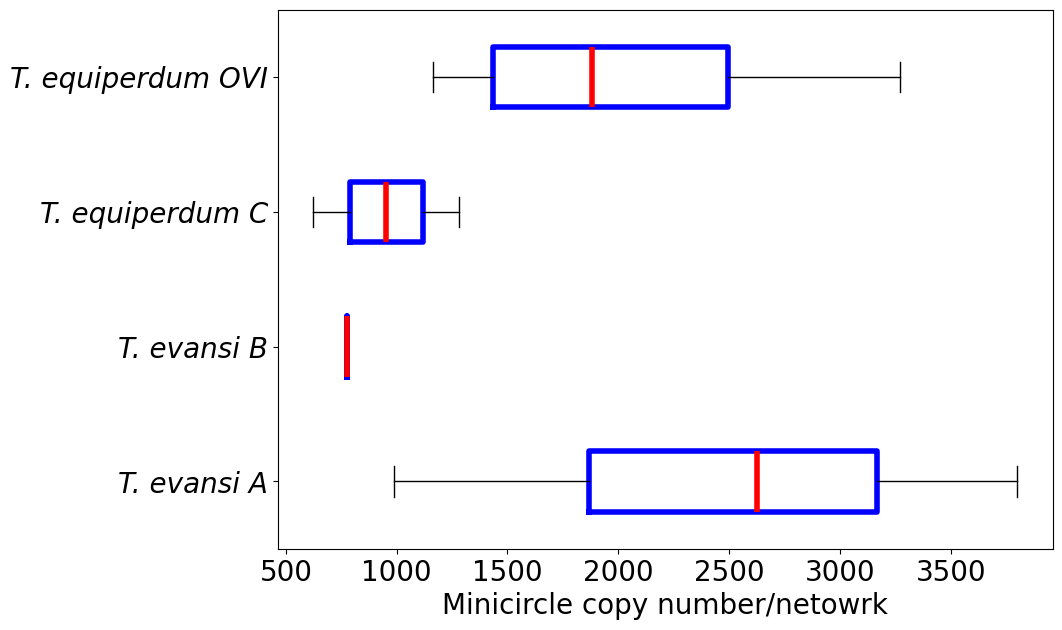

In [12]:
def plot_by_taxon(df,column):
    taxon=['T. evansi A', 'T. evansi B', 'T. equiperdum C','T. equiperdum OVI']
    for t in taxon:
        print(t)
        summary(df[df['taxon']==t][column])
    data=[df[df['taxon']==t][column] for t in taxon]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), sharey=True)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(taxon, fontsize=20,style='italic')
    ax.set_xlabel(f"Minicircle copy number/netowrk",fontsize=20)
    plt.show()

plot_by_taxon(combined[combined['mapped_csb3_percentage']>=90],'total_minicircle_cp')

In [13]:
combined[['taxon','total_minicircle_cp','maxicircle','total_csb3']]

,taxon,total_minicircle_cp,maxicircle,total_csb3
280104,T. evansi A,987.66,0.00,42872.0
940,T. equiperdum OVI,3269.77,19.72,30460.0
Alfort,T. evansi A,3801.75,0.00,151337.0
American-Strain,T. evansi A,2623.83,19.75,109707.0
AnTar-7,T. evansi A,0.00,0.00,467.0
AnTat-3-1,T. evansi A,5.05,0.00,560.0
AnTat-3-3,T. evansi A,4.83,0.00,534.0
ATCC-30019,T. evansi A,3169.51,15.83,130770.0
ATCC30019,T. evansi A,2906.84,13.15,120137.0
ATCC-30023,T. evansi A,3.22,0.00,319.0


In [14]:
#low CSB3: akinetoplastic
summary(combined[combined['mapped_csb3_percentage']>=90]['total_csb3'])
combined[combined['mapped_csb3_percentage']<90][['taxon','mapped_csb3_percentage','total_csb3','total_minicircle_cp']]

mean: 102019.32, median: 109461.5, mode: 42872.0, max: 181129.0, min: 30460.0


,taxon,mapped_csb3_percentage,total_csb3,total_minicircle_cp
AnTar-7,T. evansi A,13.0,467.0,0.00
AnTat-3-1,T. evansi A,45.0,560.0,5.05
AnTat-3-3,T. evansi A,38.0,534.0,4.83
ATCC-30023,T. evansi A,56.0,319.0,3.22
E28,T. evansi A,60.0,987.0,16.09
MCAM-ET-2013-MU-09,T. evansi A,17.0,617.0,0.35


In [15]:
#isolates with maxicircles in the network
combined[combined['maxicircle']!=0][['taxon','maxicircle']].to_csv(f"{outdir}/WGS_maxi.csv")
combined[combined['maxicircle']!=0][['taxon','maxicircle']]

,taxon,maxicircle
940,T. equiperdum OVI,19.72
American-Strain,T. evansi A,19.75
ATCC-30019,T. evansi A,15.83
ATCC30019,T. evansi A,13.15
BoTat-1-1,T. equiperdum C,10.54
BoTat-1-1-bis,T. equiperdum C,11.00
OVI,T. equiperdum OVI,14.40
Philippines,T. evansi A,13.05
STIB818,T. evansi A,23.12
Te-Ap-N-D1,T. equiperdum OVI,11.00


OVI
mean: 1003.7, median: 1001.5, mode: 1004, max: 1063, min: 966
Dodola
mean: 1000.13, median: 1001, mode: 1004, max: 1063, min: 887
Te-Ap-ND1
mean: 999.8, median: 1001, mode: 997, max: 1063, min: 842


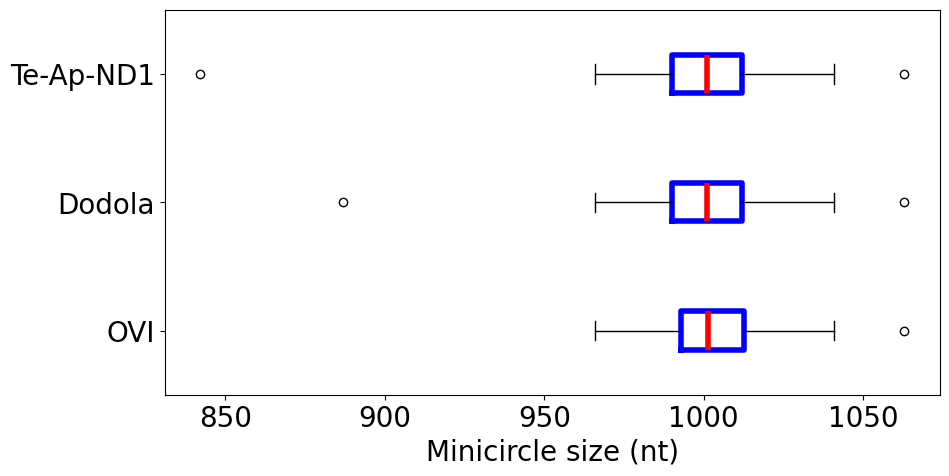

In [16]:
#type OVI minicircle length distribution
dodola_fa='/home/jovyan/Tbeqev/Infiles/clustered095_Dodola.minicircles.fasta'
ovi_fa='/home/jovyan/Tbeqev/Infiles/clustered095_OVI.minicircles.fasta'
teap_fa='/home/jovyan/Tbeqev/Infiles/clustered095_Te-Ap-N-D1.minicircles.fasta'
dodola=SeqIO.to_dict(SeqIO.parse(dodola_fa,'fasta'))
ovi=SeqIO.to_dict(SeqIO.parse(ovi_fa,'fasta'))
teap=SeqIO.to_dict(SeqIO.parse(teap_fa,'fasta'))
data={'OVI':ovi,'Dodola': dodola,'Te-Ap-ND1':teap}
def mini_circle_size(data):
    sizes={k:[len(r.seq) for m,r in v.items()]for k,v in data.items()}
    #sstats
    for k,v in sizes.items():
        print(k)
        summary(v)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot([v for k,v in sizes.items()],vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(data.keys(), fontsize=20)
    ax.set_xlabel(f"Minicircle size (nt)",fontsize=20)
    plt.show()
    return(sizes)
sizes=mini_circle_size(data)

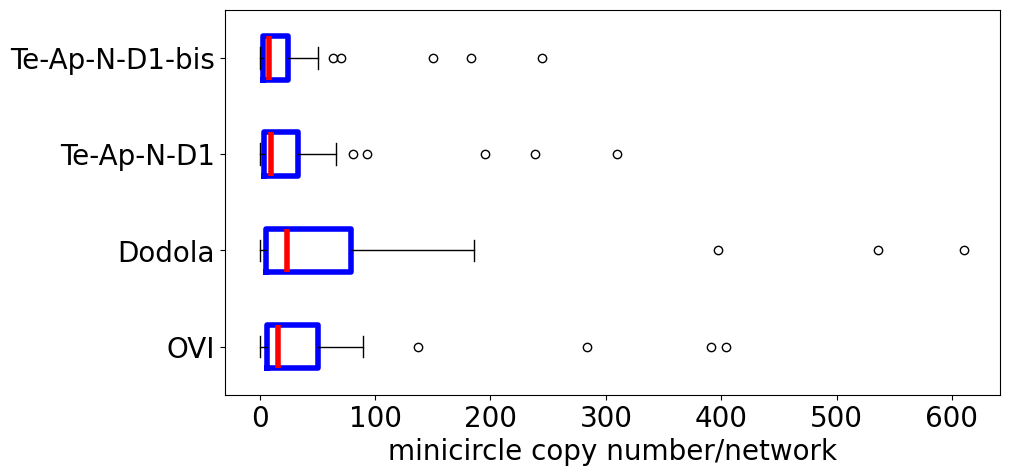

In [17]:
#type OVI minicircle copy number
def minicircle_copy_number(df):
    strains={'OVI':'OVI','940':'Dodola','Te-Ap-N-D1':'Te-Ap-N-D1','Te-Ap-N-D1-bis':'Te-Ap-N-D1-bis'}
    data={s:df[[m for m in df.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc[s].fillna(0) for s in strains}
    data={s:[i for i in v if i!=0] for s,v in data.items()}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data.values(),vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(strains.values(), fontsize=20)
    ax.set_xlabel(f"minicircle copy number/network",fontsize=20)
    plt.show()
    def numerical(data):
        for s,v in data.items():
            print(s)
            summary(v)
    #numerical(data)

minicircle_copy_number(combined)

In [18]:
#homolgos in EATRO1125
blastn='/home/jovyan/Tbeqev/Infiles/blastn_type_ABC_47_OVI.minicircles_against_clean_minicircles.txt'
def process_blastn(blastn):
    qid,save,keys='',{},['query','subject','SID','length','mismatches','gaps','query start','query end','subject start','subject end','evalue','bits core']
    for l in open(blastn):
        l=l.strip('\n').split('\t')
        if l[0]!=qid:
            save[l[0]]={k:v for k,v in zip(keys,l)}
            qid=l[0]
        else:
            continue
    return(save)
def get_EATRO1125_mini_ab(cp_nb_file,match_file):
    matches={l.split('\t')[1]:l.split('\t')[0] for l in open(match_file)}
    df=pd.read_csv(cp_nb_file)
    new=df[df.apply( lambda x : x['Minicircle'] in list(matches.keys()), axis=1 )]
    rename={'EATRO1125':{matches[name]:cpnb for name,cpnb in zip(list(new['Minicircle']),list(new['T0_WT_A']))}}
    return(rename,matches)

tophits=process_blastn(blastn)
summary([float(v['SID']) for k,v in tophits.items()])
tophits=pd.DataFrame.from_dict(tophits,orient='index')
tophits['SID']=[round(float(i),1) for i in tophits['SID']]
tophits.to_csv(f"{outdir}/top_hits.csv")
len(tophits[tophits['SID']>80])
#add copy number of mini homologs
eatro1125,matches=get_EATRO1125_mini_ab('/home/jovyan/graphing_data/EATRO1125_minicircle_copynumber.csv','/home/jovyan/graphing_data/type_OVI_ABC.minicircles_vs_clean_minicircles_hits.txt')
eatro1125=pd.DataFrame.from_dict(eatro1125,orient='index')

mean: 78.17, median: 78.782, mode: 68.738, max: 92.604, min: 66.984


In [ ]:
#homologs in Litat-1-3
blastn='/home/jovyan/Tbeqev/Infiles/blastn_LiTat-1-3.minicircles_against_type_OVI_ABC.minicircles.txt'
tophits=process_blastn(blastn)
tophits=pd.DataFrame.from_dict(tophits,orient='index')
tophits['SID']=[round(float(i),1) for i in tophits['SID']]
tophits.to_csv(f"{outdir}/Litat-1-3_top_hits.csv")
summary(tophits['SID'])
print(sorted(tophits['SID']))

In [ ]:
#compare EATRO1125 and OVI edited mRNAs
blastn='/home/jovyan/Tbeqev/Infiles/blastn_edited_mRNA_OVI_against_edited_Tb_Antat_1.1_mRNA.txt'
tophits=process_blastn(blastn)
summary([float(v['SID']) for k,v in tophits.items()])
tophits=pd.DataFrame.from_dict(tophits,orient='index')
tophits['SID']=[round(float(i),1) for i in tophits['SID']]
tophits.to_csv(f"{outdir}/edited_mRNAs_top_hits.csv")
#compare unedited mRNAs
blastn='/home/jovyan/Tbeqev/Infiles/blastn_unedited_mRNA_OVI_against_unedited_Tb_Antat_1.1_mRNA.txt'
tophits=process_blastn(blastn)
summary([float(v['SID']) for k,v in tophits.items()])
tophits=pd.DataFrame.from_dict(tophits,orient='index')
tophits['SID']=[round(float(i),1) for i in tophits['SID']]
tophits.to_csv(f"{outdir}/unedited_mRNAs_top_hits.csv")

In [ ]:
#EXtract unedited mRNAs
blastn='/home/jovyan/Tbeqev/Infiles/blastn_unedited_Tb_Antat_1.1_mRNA_against_OVI_maxicircles.txt'
maxi='/home/jovyan/Tbeqev/Infiles/OVI_maxicircles.fasta'
maxi=SeqIO.read(maxi,'fasta')
tophits=process_blastn(blastn)
summary([float(v['SID']) for k,v in tophits.items()])
tophits=pd.DataFrame.from_dict(tophits,orient='index')
tophits['SID']=[round(float(i),1) for i in tophits['SID']]
tophits.to_csv(f"{outdir}/unedited_coor.csv")
#extract hits
def extract_hits():
    records=[]
    for m in tophits.index:
        s=int(tophits.loc[m]['subject start'])
        e=int(tophits.loc[m]['subject end'])
        if s<e:
            seq=maxi.seq[s:e]
        else:
            seq=maxi.seq[e:s].reverse_complement()
        records.append(SeqRecord(seq,id=m,name='OVI',description=f'extracted from OVI maxicircle {s}-{e}'))
    SeqIO.write(records,f"{outdir}/unedited_mRNA_OVI.fasta",'fasta')

#extract_hits()

In [ ]:
#predict edited OVI
untbb='/home/jovyan/Tbeqev/Infiles/unedited_Tb_Antat_1.1_mRNA.fasta'
edtbb='/home/jovyan/Tbeqev/Infiles/edited_Tb_Antat_1.1_mRNA.fasta'
unovi=f"{outdir}/unedited_mRNA_OVI.fasta"
edovi='/home/jovyan/Tbeqev/Infiles/edited_mRNA_OVI.fasta'
####
untbb=SeqIO.to_dict(SeqIO.parse(untbb,'fasta'))
edtbb=SeqIO.to_dict(SeqIO.parse(edtbb,'fasta'))
unovi=SeqIO.to_dict(SeqIO.parse(unovi,'fasta'))
#
def count_nont(edtbb,untbb):
    for k,v in edtbb.items():
        if k.split('_')[0] in untbb:
            ed_tstrip=v.seq.upper().replace('U','T').replace('T','')
            un_tstrip=untbb[k.split('_')[0]].seq.upper().replace('U','T').replace('T','')
            if ed_tstrip==un_tstrip:
                print(f"{k},{k.split('_')[0]} have the same non-T residues")
            else:
                print(f"{k},{k.split('_')[0]} wrong")

def make_T_stripped_alignment(ed,un,otherun,outfile):
    f=open(f"{outdir}/{outfile}",'w')
    aligned={}
    for k,v in ed.items():
        if k.split('_')[0] in un:
            i,j=0,0
            edseq=v.seq.upper().replace('U','T')
            unseq=un[k.split('_')[0]].seq.upper().replace('U','T')
            aed=[]
            aun=[]
            while i < len(edseq):
                if edseq[i]==unseq[j]:
                    aed.append(edseq[i])
                    aun.append(unseq[j])
                    i+=1
                    j+=1
                elif edseq[i]=='T':
                    aed.append(edseq[i])
                    aun.append(' ')
                    i+=1
                elif unseq[j]=='T':
                    aed.append(' ')
                    aun.append(unseq[j])
                    j+=1
            f.write(f"{k}\t{''.join(aed)}\n{k.split('_')[0]}\t{''.join(aun)}\n{k.split('_')[0]}\t{otherun[k.split('_')[0]].seq}\n\n")
            aligned[k]=''.join(aed)
    f.close()
    return(aligned)

count_nont(edtbb,untbb)
#count_nont(unovi,untbb)
aligned=make_T_stripped_alignment(edtbb,untbb,unovi,'EATRO1125_ed_un_align.txt')
#after manually edit the u insertions
def add_t_to_space(edovi,aligned):
    f=open(f"{outdir}/tmp.fasta",'w')
    for l in open(edovi):
        if l.startswith('>'):
            f.write(l.replace(' ',''))
            k=l.strip('\n').replace(' ','').replace('\t','').replace('>','')
        else:
            edited=[]
            for i,j in zip(l,aligned[k]):
                #print(i,j)
                if i !=' ' and j!= ' ':
                    edited.append(i)
                elif i==' ' and j in ['A','G','C','T']:
                    edited.append('t')
                    if j!='T':
                        print(k,'i:',i,'j:',j)
                elif i=='T' and j==' ':
                    edited.append('')
                elif i==' ' and j==' ':
                    edited.append('')
                else:
                    print(i,j)
            l=''.join(edited)
            print(l)
            f.write(f"{l}\n")
    f.close()
add_t_to_space(edovi,aligned)   
edovi=SeqIO.to_dict(SeqIO.parse(f"{outdir}/tmp.fasta",'fasta'))
records=[SeqRecord(v.seq.upper(),id=k,name='edited OVI mRNAs',description='predicted from EATRO1125 by T-stripped residue alignment, 20240918') for k,v in edovi.items()]
SeqIO.write(records,f"{outdir}/edited_mRNA_OVI.fasta",'fasta')

In [ ]:
aligned

In [ ]:
combined[[m for m in combined.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc['EATRO1125'].fillna(0)

In [ ]:
#percentage of the network 
def minicircle_copy_number(df):
    strains={'940':'Dodola','OVI':'OVI','Te-Ap-N-D1':'Te-Ap-N-D1','Te-Ap-N-D1-bis':'Te-Ap-N-D1-bis'}
    data={s:df[[m for m in df.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc[s].fillna(0) for s in strains}
    data={s:[i for i in v if i!=0] for s,v in data.items()}
    for s,v in data.items():
        print(s,len(v))
        total=df['total_minicircle_cp'].loc[s]
        perc=[round(i/total*100) for i in v]
        print([i for i in perc if i>=10], len([i for i in perc if i<1]))
    return(data)

def test_correlation(s1,s2,df):
    x=df[[m for m in df.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc[s1].fillna(0)
    y=df[[m for m in df.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc[s2].fillna(0)
    #X=[i for i,j in zip(x,y) if i!=0 and j!=0]
    #Y=[j for i,j in zip(x,y) if i!=0 and j!=0]
    corr=linregress(x,y)
    print(corr)

def plot_correlation(df):
    pairs=[('Te-Ap-N-D1','OVI'),('OVI','940'),('940','Te-Ap-N-D1')]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
    for i,pair in enumerate(pairs):
        ax=axs[math.floor(i/2),i%2]
        s1,s2=pair[0],pair[1]
        x=df[[m for m in df.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc[s1].fillna(0)
        y=df[[m for m in df.columns if 'OVI_minicircle' in m or m in ['type_A','type_A_related','type_B','type_C']]].loc[s2].fillna(0)
        corr=linregress(x,y)
        ax.scatter(y,x)
        ax.set_ylim(bottom=0)
        ax.set_ylabel(f"{s1} minicircle copy number")
        ax.set_xlabel(f"{s2} minicircle copy number")
        ax.text(max(y),max(x),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \nP={round(corr.pvalue,5)}",ha='right',va='top')
    plt.show()
    
data=minicircle_copy_number(combined)
test_correlation('Te-Ap-N-D1','Te-Ap-N-D1-bis',combined)
#test_correlation('Te-Ap-N-D1','OVI',combined)
#test_correlation('Te-Ap-N-D1','940',combined)
#test_correlation('OVI','940',combined)
#test_correlation('OVI','EATRO1125',combined)
#plot_correlation(combined) #need to use log , use the old fig